# Food Classification
**Problem Statement:** Food classification using DeepLearning

**Author:** Raja Sandeep Mukkala

**Affiliation:** Seattle University

**Course:** DATA-5100 Foundation of Data Science

**Professor:** Dr. Brian Fischer

**Date:** November 05, 2025

**Introduction:**

- Food recognition has applications like diet tracking, calorie estimation etc., Manual food identification is a time consuming. This project applies deep learning techniques like transfer learning using ResNet34 and ResNet50 with Fastai library to classify food images into 11 categories from the Kaggle food-11 dataset.

- Python libraries that are used are fastai, fastcore, pillow, builtins, posixpath, matplotlib and seaborn for visualization and analysis purpose.

**Data Source:**

- **Source:**
    - [Kaggle - Food-11 Image Dataset](https://www.kaggle.com/datasets/trolukovich/food11-image-dataset)
- **Description:**
    - Kaggle - Food-11 Image Dataset: Contains images from 11 different food classes like Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, Vegetable/Fruit with a total of approx. 16,643 images that are divided in training, validation and evaluation folders. And image type is RGB with variable resolution

### Enable Kaggle API

In [1]:
from google.colab import files

# choose kaggle.json you just downloaded
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Download and Unzip Food-11 dataset

In [2]:
!kaggle datasets download -d trolukovich/food11-image-dataset
!unzip -q food11-image-dataset.zip -d food11
!find food11 -maxdepth 1 -type d -print

Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset
License(s): CC0-1.0
100% 1.08G/1.08G [00:08<00:00, 79.1MB/s]
100% 1.08G/1.08G [00:08<00:00, 140MB/s] 
food11
food11/validation
food11/evaluation
food11/training


### Import the `fastai` library

Import all items from `fastai.vision.all`

Import all items from `fastcore.all`

In [3]:
from fastai.vision.all import *
from fastcore.all import *
from PIL import Image
import builtins,cv2
import posixpath

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

- Imported Fastai vision tools for image loading, model training and evaluation.
- Imported Fastcore utility functions that are used by Fastai.
- Imported Pillow to open and process image files.
- Imported OpenCV to do image operations like reading.
- Imported matplotlib and seaborn for visualisation and plots.

### Load the data

In [4]:
file_names = get_image_files('food11/')

# Skip the unreadable images
failed = verify_images(file_names)
failed.map(Path.unlink)

print(f'We have {len(file_names)} images\n')
print("Diplaying path for image dataset: \n")
for file_name in file_names[:5]:
    print(file_name,'\n')

We have 16643 images

Diplaying path for image dataset: 

food11/validation/Meat/120.jpg 

food11/validation/Meat/96.jpg 

food11/validation/Meat/53.jpg 

food11/validation/Meat/352.jpg 

food11/validation/Meat/160.jpg 



- Collected all the images from food11 dataset folder.
- Checked for any unreadable/corrupted images and removed the corrupted image files.
- And displayed number of images and few sample image paths from the dataset.

### Displaying an image and its size in the dataset

Image size: 
 (512, 512)


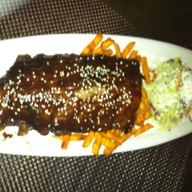

In [5]:
# selecting an image
img = PILImage.create(file_names[65])

print('Image size: \n',img.size)
# plot the image
img.to_thumb(192)

- Loaded an image from the dataset to verify that images are loaded correctly.

### Data processing

Adding labels to the loaded dataset

In [6]:
def label_function(file_name):
    path_info = posixpath.split(file_name)
    image_path_info = path_info[0].split('/')
    return image_path_info[-1]

- Assigned correct class labels to each image based on its folder structure.

In [7]:
def cv2_to_pil_rgb(p:Path):
    path_string = builtins.str(p)
    img = cv2.imread(path_string, cv2.IMREAD_COLOR)
    if img is None: raise OSError('Unreadable image')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return PILImage(Image.fromarray(img))

- All images are read and converted into RGB format before processing in the model.

#### Setting up data splitting and transformations

In [8]:
splitter = GrandparentSplitter(train_name='training', valid_name='validation')

item_tfms = [Resize(224)]

batch_tfms = [
    *aug_transforms(
        size=224,
        max_rotate=10,
        max_zoom=1.05,
        max_warp=0.0,
        max_lighting=0.2,
        p_affine=0.7, p_lighting=0.7
    ),
    Normalize.from_stats(*imagenet_stats),
    RandomErasing(p=0.2)
]

To improve accuracy and generalization of model, transformations are applied on images.
- Splitted the dataset into training and validation sets based on folder names.
- Resized the images to 224 x 224.
- Added transformations to image batches during training.
  - Augumentations like rotations, zoom and lighting changes are added using `aug_transforms`
  - Normalized images using ImageNets's mean and standard deviation.
  -  `RandomErasing(p=0.2)` Randomly erased image patches.

### Defining the DataBlock

In [9]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = label_function,
                   get_x = cv2_to_pil_rgb,
                   splitter = splitter,
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)

DataBlock is created to organize how images and labels are loaded, transformed and prepared for model.
- block = (ImageBlock, CategoryBlock) specified the input type as images and output type as categories.
- get_items retireves image file paths from dataset folder.
- get_y takes custom label function that extract labels from image paths.
- splitter,  splited the data into training and validation sets based on folder structure.
- get_x is asigned a function that loads and converts images to RGB format.
- item_tfms, applied resizing of image  to 224x224
- batch_tfms applied batch level trasnformation like augumentation, normalisation and random erasing.

### Creating the DataLoader

In [10]:
path = Path('food11/')
dls = dblock.dataloaders(path, bs=64, num_workers=0)
print('Classes: ', len(dls.vocab), "\n")
print(dls.vocab, "\n")

Classes:  11 

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit'] 



- Prepared the dataset for trainng and organised images into 11 labeled food categories.
  - path is set to dataset folder.
  - DataLoader is created from DataBlock.
  - batch size is set to 64.
  - number of workers is set 0(i.e single threaded loading)
- Food categories are diplayed.
- Class labels are printed.  

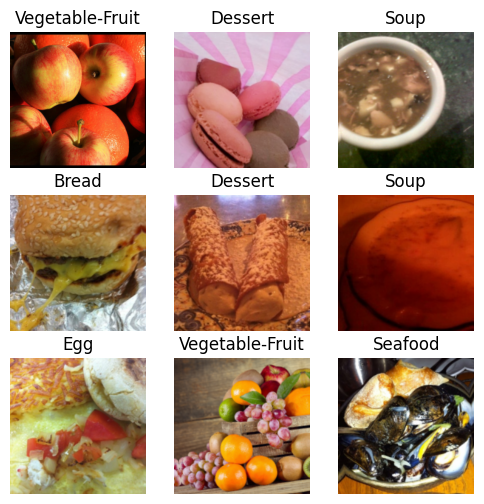

In [11]:
dls.show_batch(figsize=(6,6))

### Train and Test

#### ResNet34

#### Training the Model using ResNet34

In [12]:
learn_34 = vision_learner(dls, resnet34, metrics=[accuracy, top_k_accuracy]).to_fp16()
learn_34.loss_func = CrossEntropyLossFlat(label_smoothing=0.05)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 139MB/s]


- Created a learner using ResNet34 and provided accuracy and top-k accuracy as performance metrics.
- Enabled mixed precision training to allow faster computation and less memory usage.
- Loss function is set with labeled smoothing.

#### Fine Tuning and finding optimal learning rate.

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.579042,0.652228,0.888047,0.993294,02:01


Better model found at epoch 0 with accuracy value: 0.8880466222763062.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.575452,0.647754,0.882799,0.993003,01:55
1,0.527780,0.586762,0.903207,0.994461,01:53
2,0.457152,0.560608,0.908746,0.994169,01:54


Better model found at epoch 0 with accuracy value: 0.8827988505363464.
Better model found at epoch 1 with accuracy value: 0.903207004070282.
Better model found at epoch 2 with accuracy value: 0.9087463617324829.


Best Starting LR:  0.0002290867705596611 



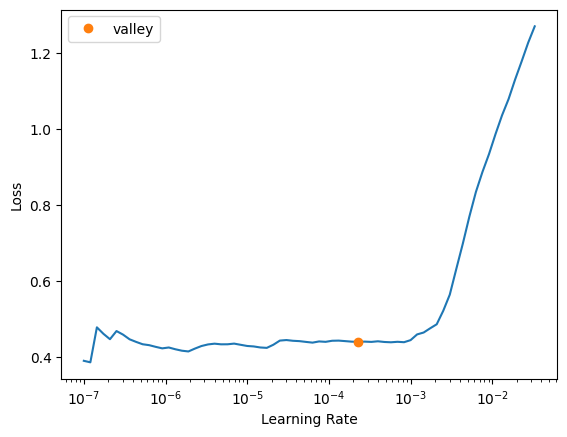

In [14]:
learn_34.fine_tune(3, cbs=[SaveModelCallback(monitor='accuracy', fname='best_34')])

lrs_34 = learn_34.lr_find()
print('Best Starting LR: ', lrs_34.valley, '\n')

- Fine tuning the pretrained ResNet34 for 3 epochs.
- Ran Fastai's Learning Rate Finder to identify optimal learning rate.
- Learning rate plot showed how loss changes with learning rate, `valley` point indicates the best starting LR as 0.0002290867705596611

#### Unfreezing and Fine tunning the entire model

In [15]:
learn_34.unfreeze()
suggested_lr_34 = lrs_34.valley
learn_34.fit_one_cycle(20, lr_max=slice(suggested_lr_34/10, suggested_lr_34),
                    cbs=[SaveModelCallback(monitor='accuracy', fname='best_ft_34'),
                         EarlyStoppingCallback(monitor='accuracy', patience=5)])

# Load the single best epoch across both phases:
learn_34.load('best_ft_34', with_opt=False)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.436495,0.551528,0.910496,0.994169,01:53
1,0.409736,0.550902,0.913703,0.994461,01:55
2,0.406311,0.553609,0.909329,0.995044,01:54
3,0.418506,0.545875,0.911953,0.994752,01:55
4,0.415467,0.576419,0.899125,0.992420,01:54
5,0.392787,0.556848,0.904665,0.993586,01:54
6,0.407086,0.580684,0.899125,0.992711,01:55


Better model found at epoch 0 with accuracy value: 0.9104956388473511.
Better model found at epoch 1 with accuracy value: 0.9137026071548462.
No improvement since epoch 1: early stopping


- Unfreezed all layers of ResNet34 model so that earlier layers can also be fine tuned.
- Used the optimal learning rate obtained from LR finder.
- Trained the model for 20 epochs using the one clycle learning rate policy.
- Saved the model when higher validation accuracy is achieved.
- Stopped training if the model accuracy doesn't improves for 5 epochs to prevent overfitting.
- Loaded the best performing weights across all training phases.

### ResNet50

#### #### Training the Model using ResNet50

In [16]:
learn_50 = vision_learner(dls, resnet50, metrics=[accuracy, top_k_accuracy]).to_fp16()
learn_50.loss_func = CrossEntropyLossFlat(label_smoothing=0.05)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


- Created a learner using ResNet50 and provided accuracy and top-k accuracy as performance metrics.
- Enabled mixed precision training to allow faster computation and less memory usage.
- Loss function is set with labeled smoothing.

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.609000,0.675965,0.874927,0.988921,02:06


Better model found at epoch 0 with accuracy value: 0.8749271035194397.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.578082,0.600962,0.902915,0.992711,02:13
1,0.513363,0.574812,0.899417,0.993003,02:13
2,0.449305,0.548558,0.909913,0.994169,02:13


Better model found at epoch 0 with accuracy value: 0.9029154777526855.
Better model found at epoch 2 with accuracy value: 0.9099125266075134.


Best Starting LR:  0.00013182566908653826 



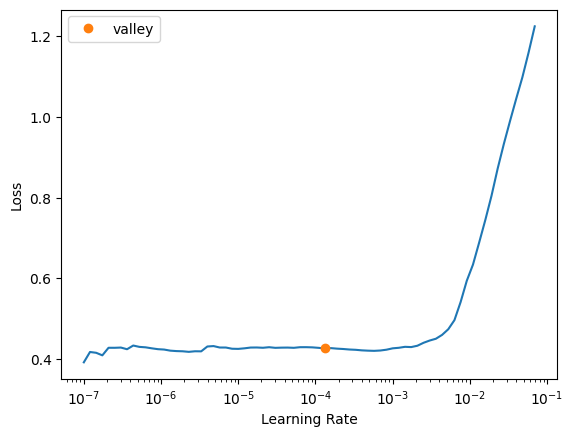

In [18]:
learn_50.fine_tune(3, cbs=[SaveModelCallback(monitor='accuracy', fname='best_50')])

lrs_50 = learn_50.lr_find()
print('Best Starting LR: ', lrs_50.valley, '\n')

- Fine tuning the pretrained ResNet50 for 3 epochs.
- Ran Fastai's Learning Rate Finder to identify optimal learning rate.
- Learning rate plot showed how loss changes with learning rate, `valley` point indicates the best starting LR as 0.00013182566908653826

In [19]:
learn_50.unfreeze()
suggested_lr_50 = lrs_50.valley
learn_50.fit_one_cycle(20, lr_max=slice(suggested_lr_50/10, suggested_lr_50),
                    cbs=[SaveModelCallback(monitor='accuracy', fname='best_ft_50'),
                         EarlyStoppingCallback(monitor='accuracy', patience=5)])

# Load the single best epoch across both phases:
learn_50.load('best_ft_50', with_opt=False)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.433378,0.537465,0.918659,0.995627,02:11
1,0.428512,0.545480,0.913120,0.994169,02:11
2,0.426634,0.538659,0.914286,0.995044,02:11
3,0.419754,0.542386,0.913411,0.994752,02:11
4,0.408268,0.525097,0.919825,0.995044,02:11
5,0.388884,0.522745,0.917493,0.996210,02:11
6,0.398918,0.515109,0.924781,0.994752,02:10
7,0.382789,0.501183,0.929446,0.995627,02:11
8,0.361897,0.495377,0.928863,0.995918,02:11
9,0.367420,0.498883,0.928280,0.995335,02:11


Better model found at epoch 0 with accuracy value: 0.9186589121818542.
Better model found at epoch 4 with accuracy value: 0.9198250770568848.
Better model found at epoch 6 with accuracy value: 0.924781322479248.
Better model found at epoch 7 with accuracy value: 0.9294460415840149.
Better model found at epoch 10 with accuracy value: 0.930320680141449.
Better model found at epoch 13 with accuracy value: 0.9314869046211243.
Better model found at epoch 14 with accuracy value: 0.9341107606887817.
Better model found at epoch 15 with accuracy value: 0.9355685114860535.


- Unfreezed all layers of ResNet50 model so that earlier layers can also be fine tuned.
- Used the optimal learning rate obtained from LR finder.
- Trained the model for 20 epochs using the one clycle learning rate policy.
- Saved the model when higher validation accuracy is achieved.
- Stopped training if the model accuracy doesn't improves for 5 epochs to prevent overfitting.
- Loaded the best performing weights across all training phases.

### Comparing validation accuracies of ResNet34 and ResNet50

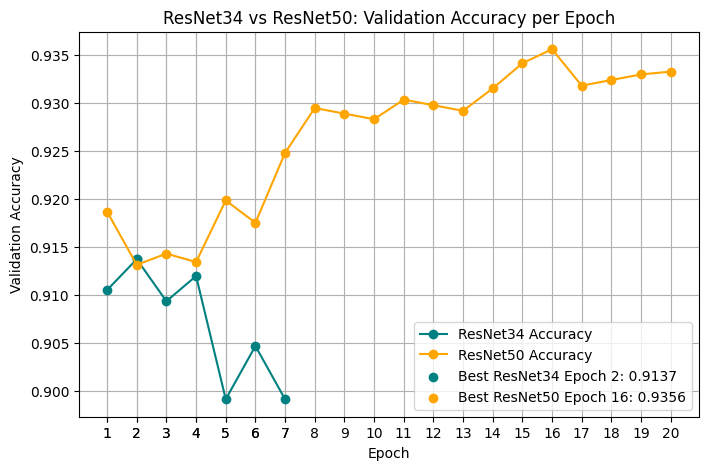

In [25]:
accs_34 = [v[2] for v in learn_34.recorder.values]  # accuracy for ResNet34

accs_50 = [v[2] for v in learn_50.recorder.values]  # accuracy for ResNet50

# Fix x-axis to 1–20
epochs_34 = np.arange(1, len(accs_34)+1)
epochs_50 = np.arange(1, len(accs_50)+1)

epochs = np.concatenate((epochs_34, epochs_50))

plt.figure(figsize=(8, 5))
plt.plot(epochs_34, accs_34, marker='o', color='teal', label='ResNet34 Accuracy')
plt.plot(epochs_50, accs_50, marker='o', color='orange', label='ResNet50 Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('ResNet34 vs ResNet50: Validation Accuracy per Epoch')
plt.xticks(epochs)   # show all epoch numbers
plt.grid(True)

# Highlight best epochs
best_epoch_34 = accs_34.index(max(accs_34)) + 1
best_epoch_50 = accs_50.index(max(accs_50)) + 1

plt.scatter(best_epoch_34, max(accs_34), color='teal',
            label=f'Best ResNet34 Epoch {best_epoch_34}: {max(accs_34):.4f}')
plt.scatter(best_epoch_50, max(accs_50), color='orange',
            label=f'Best ResNet50 Epoch {best_epoch_50}: {max(accs_50):.4f}')

plt.legend()
plt.show()

- ResNet50 consistently achieves higher validation accuracy than ResNet34.
- ResNet50 improved continuosly and reached best accuracy of 0.9356 at epoch 16.
- ResNet34 reached best accuracy of 0.9137 at epoch 2.
- ResNet50 outperforms ResNet34.  

#### Creating Classification Interpretation Objects

In [26]:
interp_34 = ClassificationInterpretation.from_learner(learn_34)
interp_50 = ClassificationInterpretation.from_learner(learn_50)

- Generated interpretation objects for ResNet34 model.
- Generated interpretation objects for ResNet50 model.

### Confusion Matrix
#### ResNet34

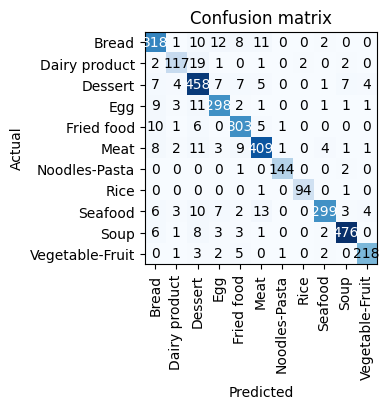

In [27]:
interp_34.plot_confusion_matrix(figsize=(4,4))

- There is some overlap in classification of Dessert and Bread due to same texture or color.
- And some overlap exists between Meat and Fried Food and also between Seafood and Vegetable-Fruit
- It accurately classified food type like Soup, Dessert and Meat.
- Confusion between certain food types is due to color or texture similarities.

ResNet50

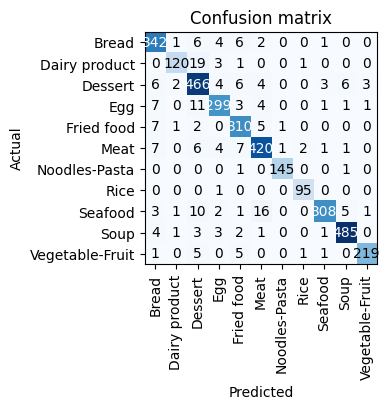

In [28]:
interp_50.plot_confusion_matrix(figsize=(4,4))

- There is overlap in classification between Dessert and Bread, Meat and Fried Food, Seafood and Meat. Due to color or texture similarities.

Overall ResNet50 out performs ResNet34 in accuarte classification of food category.

### ResNet32: Ploting top losses

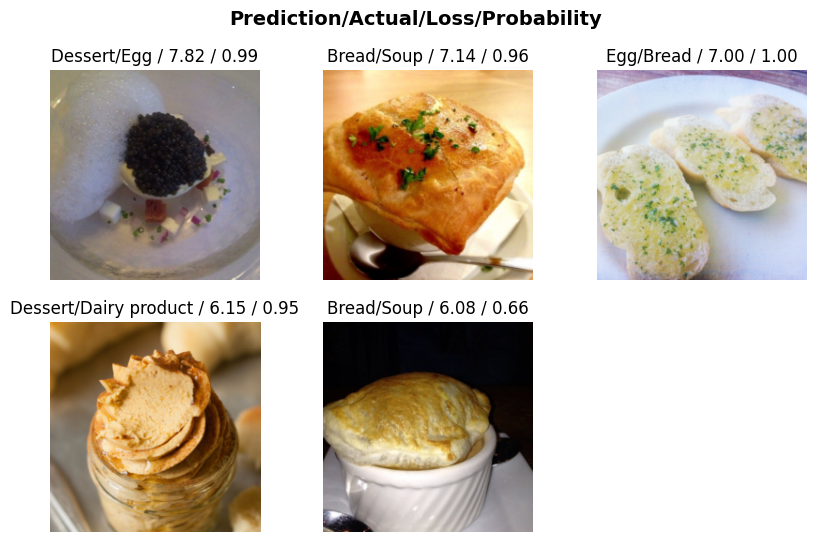

In [29]:
interp_34.plot_top_losses(5, figsize=(10,6))

- Egg is misclassified as Dessert, Soup misclassified as Bread, Bread misclassified ad Egg, Dairy product misclassified and Dessert and Soup misclassified as Bread. All these misclassification is due to similar color and texture.
- ResNet34 model is struggling in classify food of samilar texture and color.

### ResNet50: Ploting top losses

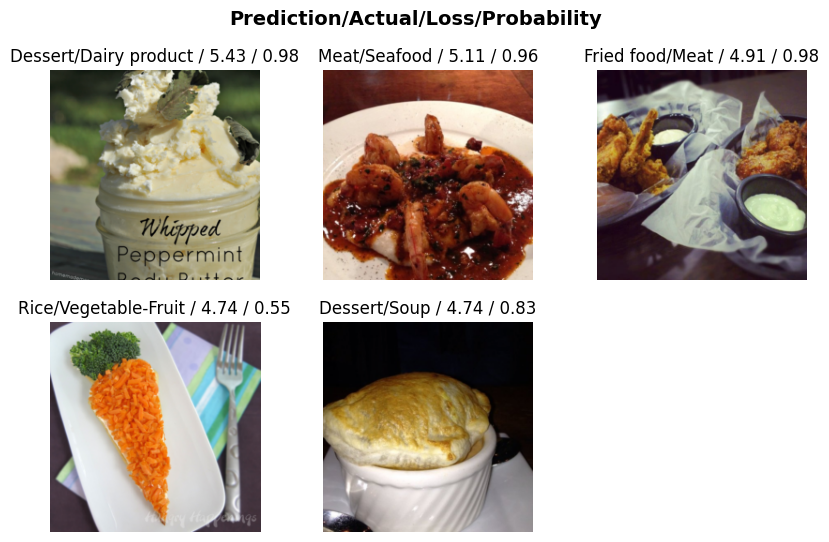

In [30]:
interp_50.plot_top_losses(5, figsize=(10,6))

- Dairy Product misclassified as Dessert, Seafood misclassified as Meat, Meat is misclassified as Fried food, Vegetable Fruite misclassified as Rice and Soup misclassified as Dessert.
- ResNet50 is also geting confused in classify food of similar texture and color.

- Loss of ResNet50 is lower than ResNet34, which indicates ResNet50 model performs better than ResNet34 on validation data

### Deployment

#### Downloaded images from interent which are not in dataset to test the trained model

#### Ploting Predictions

ResNet34: Prediction:  Soup  Probability:  tensor(0.9365)


ResNet50: Prediction:  Soup  Probability:  tensor(0.9755)


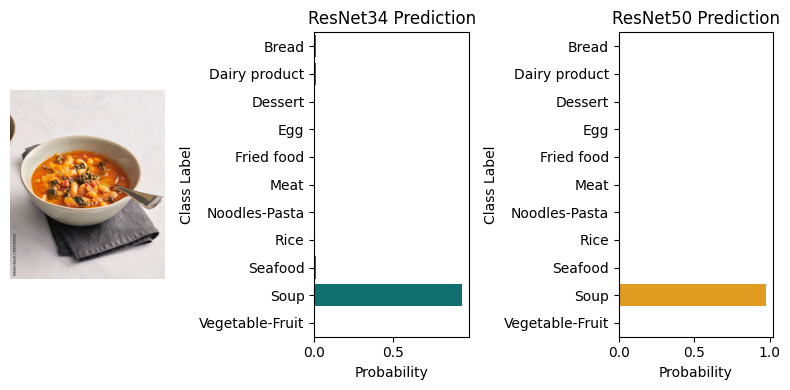

ResNet34: Prediction:  Dessert  Probability:  tensor(0.9174)


ResNet50: Prediction:  Dessert  Probability:  tensor(0.9431)


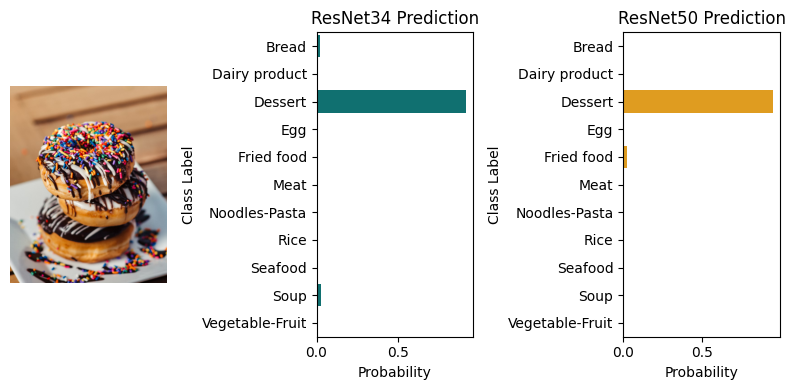

ResNet34: Prediction:  Rice  Probability:  tensor(0.9915)


ResNet50: Prediction:  Rice  Probability:  tensor(0.9531)


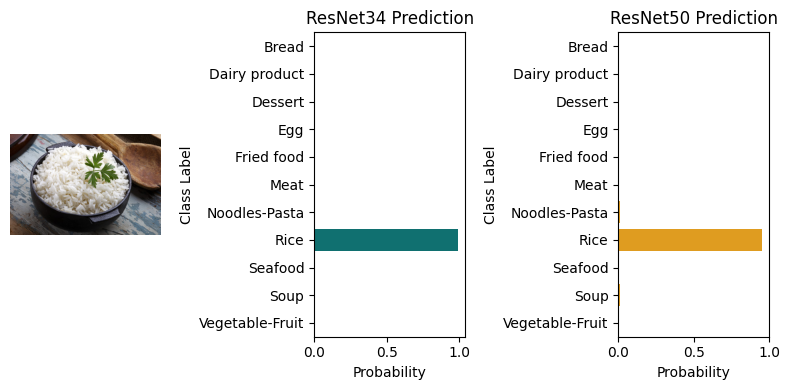

ResNet34: Prediction:  Bread  Probability:  tensor(0.9078)


ResNet50: Prediction:  Bread  Probability:  tensor(0.6521)


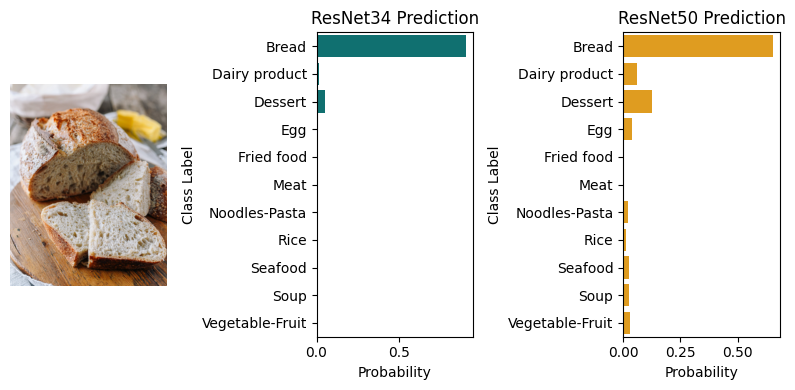

ResNet34: Prediction:  Fried food  Probability:  tensor(0.9037)


ResNet50: Prediction:  Fried food  Probability:  tensor(0.7963)


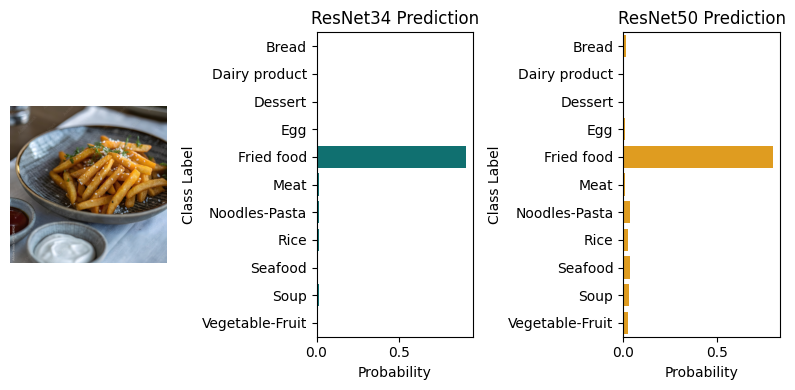

ResNet34: Prediction:  Dairy product  Probability:  tensor(0.7626)


ResNet50: Prediction:  Egg  Probability:  tensor(0.9001)


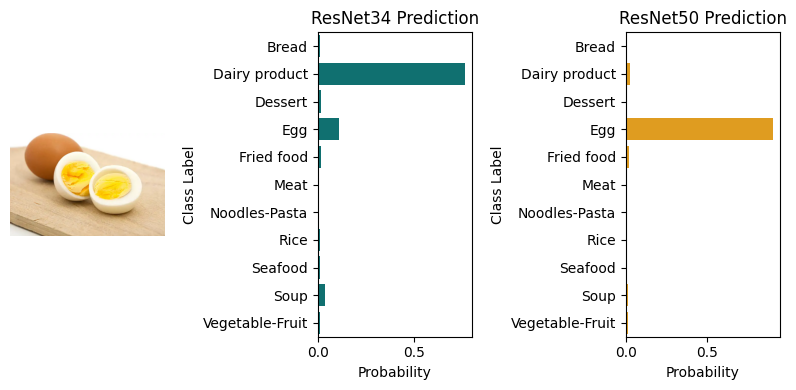

ResNet34: Prediction:  Vegetable-Fruit  Probability:  tensor(0.9886)


ResNet50: Prediction:  Vegetable-Fruit  Probability:  tensor(0.9617)


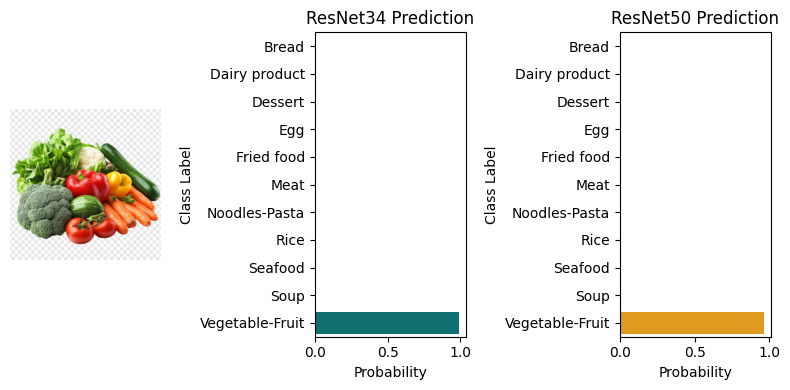

ResNet34: Prediction:  Noodles-Pasta  Probability:  tensor(0.9706)


ResNet50: Prediction:  Noodles-Pasta  Probability:  tensor(0.9891)


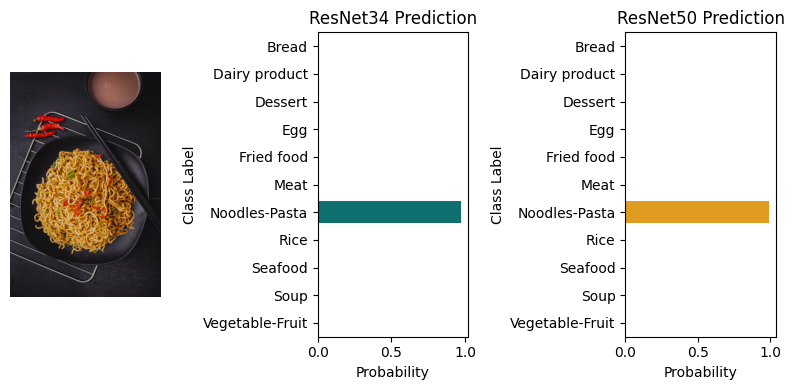

ResNet34: Prediction:  Noodles-Pasta  Probability:  tensor(0.5610)


ResNet50: Prediction:  Seafood  Probability:  tensor(0.5226)


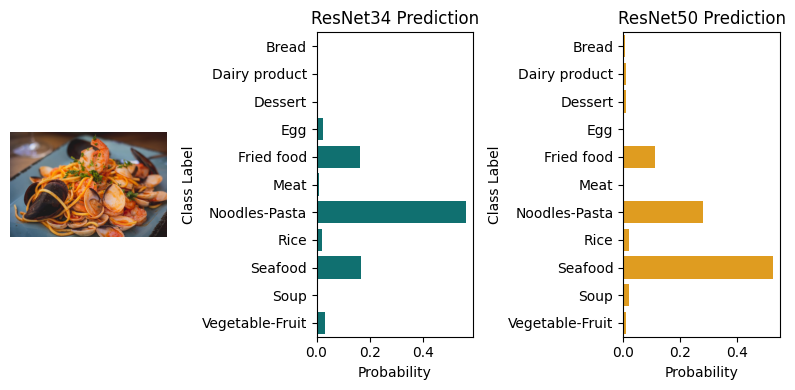

ResNet34: Prediction:  Dairy product  Probability:  tensor(0.9953)


ResNet50: Prediction:  Dairy product  Probability:  tensor(0.7888)


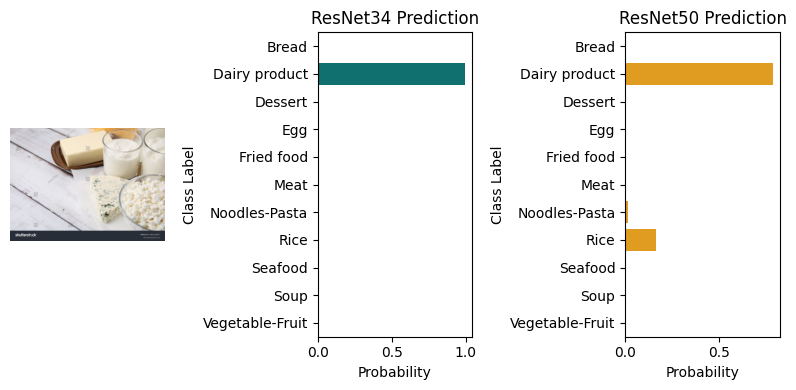

ResNet34: Prediction:  Meat  Probability:  tensor(0.8734)


ResNet50: Prediction:  Meat  Probability:  tensor(0.9504)


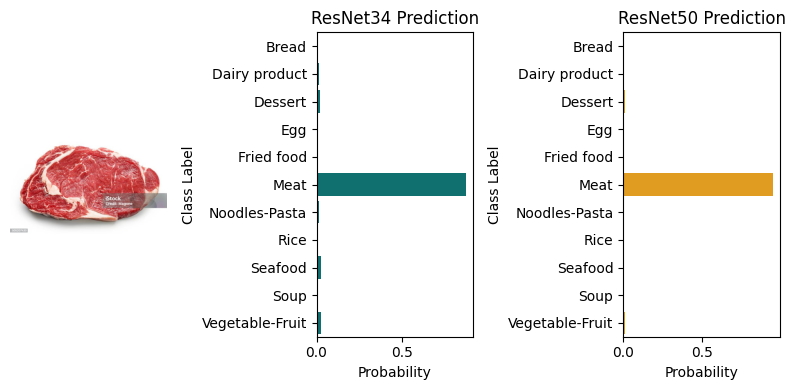

In [36]:
file_names = get_image_files('test/')

for file_name in file_names:
  img = Image.open(file_name).convert("RGB")
  img_resized = img.resize((512, 512), Image.Resampling.LANCZOS)

  prediction_34,_,probs_34 = learn_34.predict(img_resized)
  print('ResNet34: Prediction: ', prediction_34, ' Probability: ', max(probs_34))
  prediction_50,_,probs_50 = learn_50.predict(img_resized)
  print('ResNet50: Prediction: ', prediction_50, ' Probability: ',max(probs_50))

  fig, axes = plt.subplots(1,3, figsize=(8,4))

  # Display the image in the first subplot
  axes[0].imshow(img)
  axes[0].axis('off')
  # axes[0].set_title(f"Prediction: {prediction_32}")

  # Plot the bar plot in the second subplot
  sns.barplot(x=probs_34, y=dls.vocab, orient='h', ax=axes[1], color='teal')
  axes[1].set_xlabel('Probability')
  axes[1].set_ylabel('Class Label')
  axes[1].set_title('ResNet34 Prediction')

  sns.barplot(x=probs_50, y=dls.vocab, orient='h', ax=axes[2], color='orange')
  axes[2].set_xlabel('Probability')
  axes[2].set_ylabel('Class Label')
  axes[2].set_title('ResNet50 Prediction')

  plt.tight_layout()
  plt.show()


- Both models accurately predicted unseen images. But out of these two, ResNet50 performed well in classifying all the 11 unseen images accurately where as ResNet34 has two misclassifications and only classified 9 correctly.
- One of the reason is ResNet50 has deeper neural net compared to ResNet34